In [1]:
import random
import numpy as np
import tensorflow.keras
#import wandb
#from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# load data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

11493376/11490434 [==============================] - 2s 0us/step


In [3]:
x_train[0].shape

(28, 28)

In [6]:
np.where(y_train == 5)[0]

array([    0,    11,    35, ..., 59968, 59993, 59997])

In [7]:
y_train[35]

5

In [13]:
random.choice([1,2,3,1,3,4,3,2,2,3,3,3])

2

In [14]:
random.randint(0, 9)

6

In [15]:
# make pairs
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    #print(digit_indices)
    #print('len *****', len(digit_indices))
    #print('3 digit array', digit_indices[3])
    
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

In [16]:
x_train.shape

(60000, 28, 28)

In [17]:
pairs_train.shape

(120000, 2, 28, 28)

In [14]:
labels_train.shape

(120000,)

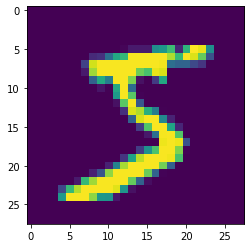

In [18]:
# take a peek at the data
plt.imshow(pairs_train[0,0])

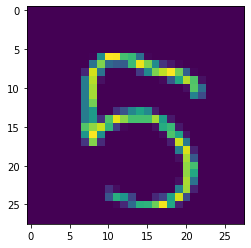

In [19]:
plt.imshow(pairs_train[0,1])

In [20]:
labels_train[0]

1

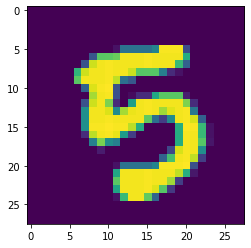

In [21]:
plt.imshow(pairs_train[1109,0])

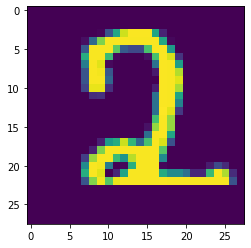

In [22]:
plt.imshow(pairs_train[1109,1])

In [23]:
labels_train[1109]

0

In [24]:
# Weights not shared

seq1 = Sequential()
seq1.add(Flatten(input_shape=(28,28)))
seq1.add(Dense(128, activation='relu'))

seq2 = Sequential()
seq2.add(Flatten(input_shape=(28,28)))
seq2.add(Dense(128, activation='relu'))

merge_layer = Concatenate()([seq1.output, seq2.output])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[seq1.input, seq2.input], outputs=dense_layer)

In [25]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs= 10)

Epoch 1/10
7500/7500 [==============================] - 8s 987us/step - loss: 0.6979 - accuracy: 0.4985
Epoch 2/10
7500/7500 [==============================] - 8s 1ms/step - loss: 0.6932 - accuracy: 0.5035
Epoch 3/10
7500/7500 [==============================] - 9s 1ms/step - loss: 0.6929 - accuracy: 0.5089
Epoch 4/10
7500/7500 [==============================] - 8s 1ms/step - loss: 0.6926 - accuracy: 0.5121
Epoch 5/10
7500/7500 [==============================] - 8s 1ms/step - loss: 0.6921 - accuracy: 0.5174
Epoch 6/10
7500/7500 [==============================] - 9s 1ms/step - loss: 0.6920 - accuracy: 0.5146
Epoch 7/10
7500/7500 [==============================] - 9s 1ms/step - loss: 0.6910 - accuracy: 0.5184
Epoch 8/10
7500/7500 [==============================] - 9s 1ms/step - loss: 0.6904 - accuracy: 0.5183
Epoch 9/10
7500/7500 [==============================] - 9s 1ms/step - loss: 0.6898 - accuracy: 0.5212
Epoch 10/10
7500/7500 [==============================] - 9s 1ms/step - loss: 0.6

In [27]:
from tensorflow.keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    #return K.sqrt(K.maximum(sum_square, K.epsilon()))
    return K.sqrt(sum_square)


input = Input((28,28))
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)

In [28]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128)          100480      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model_1[0][0]              

In [29]:
pairs_train[:,0].shape

(120000, 28, 28)

In [30]:
pairs_train[:,1].shape

(120000, 28, 28)

In [31]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 9s 1ms/step - loss: nan - accuracy: 0.4992
Epoch 2/10
7500/7500 [==============================] - 9s 1ms/step - loss: nan - accuracy: 0.5006
Epoch 3/10
7500/7500 [==============================] - 9s 1ms/step - loss: nan - accuracy: 0.5030
Epoch 4/10
7500/7500 [==============================] - 10s 1ms/step - loss: nan - accuracy: 0.5006
Epoch 5/10
7500/7500 [==============================] - 9s 1ms/step - loss: nan - accuracy: 0.5032
Epoch 6/10
7500/7500 [==============================] - 10s 1ms/step - loss: nan - accuracy: 0.5001
Epoch 7/10
7500/7500 [==============================] - 10s 1ms/step - loss: nan - accuracy: 0.4993
Epoch 8/10
7500/7500 [==============================] - 9s 1ms/step - loss: nan - accuracy: 0.5008
Epoch 9/10
7500/7500 [==============================] - 9s 1ms/step - loss: nan - accuracy: 0.4968
Epoch 10/10
7500/7500 [==============================] - 9s 1ms/step - loss: nan - accuracy: 0.5005


Kaggle - Challenges in Representation Learning: Facial Expression Recognition Challenge
  * https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/discussion
  * https://www.youtube.com/watch?v=DtBu1u5aBsc

Sliding Window Classifier: Rain Drop Detection
  * https://github.com/tobybreckon/raindrop-detection-cnn/blob/master/raindrop_detection_sliding_window.py

Convolutional implementation of the sliding window algorithm
  * https://medium.com/ai-quest/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0